# Spam Detection with Neural Networks

A common use for binary classification is sorting spam e-mails from legitimate e-mails. It's not difficult to build a neural network that classifies text. Let's use Keras to build a binary classifier for e-mails, train it with a collection of e-mails labeled with 0s (for not spam) and 1s (for spam), and then run a few e-mails through it to see how well it performs.

## Load and prepare the data

The first step is to load the dataset and prepare it for use in deep learning. We'll use Keras's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class to vectorize the text in the training e-mails. We won't bother to remove stop words because doing so has little to no effect on the outcome.

In [1]:
import pandas as pd
 
df = pd.read_csv('Data/ham-spam.csv')
df = df.sample(frac=1, random_state=0)
df.head()

,IsSpam,Text
993,1,utf date course utf diminish weight our table...
859,1,utf any drugs eur utf for dose have you ever ...
298,0,expert finderhttps expertfinder enron com
553,1,and courtiers ministerssubsegment founded res...
672,1,for our clients fargo dear customer have updat...


Remove duplicate rows from the dataset and check for balance.

In [2]:
df = df.drop_duplicates()
df.groupby('IsSpam').describe()

Text                                                               
       count unique                                                top freq
IsSpam                                                                     
0        499    499         expert finderhttps expertfinder enron com     1
1        500    500   utf date course utf diminish weight our table...    1

Extract text from the "Text" column and labels from the "IsSpam" column. Then tokenize the text and create padded sequences from it.

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
x = df['Text']
y = df['IsSpam']

max_words = 10000 # Limit the vocabulary to the 10,000 most common words
max_length = 500
 
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
x = pad_sequences(sequences, maxlen=max_length)

## Train a neural network to identify spam

Create a neural network containing an [`Embedding`](https://keras.io/api/layers/core_layers/embedding/) layer for converting sequences into arrays of word vectors and a [`Dense`](https://keras.io/api/layers/core_layers/dense/) layer for classifying arrays of word vectors.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding
 
model = Sequential() 
model.add(Embedding(max_words, 32, input_length=max_length)) 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

/Users/marlenepostop/Documents/Applied-Machine-Learning/tf_mps/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Train the network.

In [5]:
hist = model.fit(x, y, validation_split=0.2, epochs=5, batch_size=20)

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5845 - loss: 0.6761 - val_accuracy: 0.6800 - val_loss: 0.5809
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8748 - loss: 0.3272 - val_accuracy: 0.8450 - val_loss: 0.3079
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9637 - loss: 0.0930 - val_accuracy: 0.9400 - val_loss: 0.1417
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9925 - loss: 0.0254 - val_accuracy: 0.9600 - val_loss: 0.1322
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9912 - loss: 0.0188 - val_accuracy: 0.9600 - val_loss: 0.1348


Chart the training and validation accuracy for each epoch.

[]

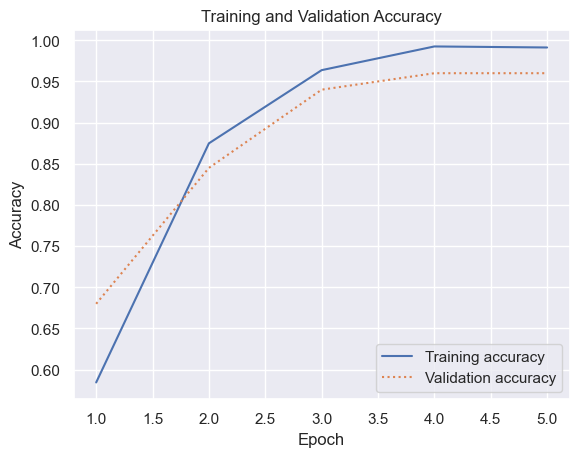

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
 
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

## Use the model to classify e-mails

Now let's see how the model classifies some sample e-mails. We'll start with a message that is not spam. The model's `predict` method predicts the probability that the input belongs to the positive class (spam).

In [8]:
text = 'Can you attend a code review on Tuesday? ' \
       'Need to make sure the logic is rock solid.'

sequence = tokenizer.texts_to_sequences([text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


np.float32(0.69648314)

Now test the model with a spam message.

In [9]:
text = 'Why pay more for expensive meds when ' \
       'you can order them online and save $$$?'

sequence = tokenizer.texts_to_sequences([text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


np.float32(0.9966029)

What did the network predict for the first e-mail? What about the second? Do you agree with the predictions? Remember that a number close to 0.0 indicates that the e-mail is not spam, while a number close to 1.0 indicates that it is.

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding
from tensorflow.keras.layers import TextVectorization, InputLayer
import tensorflow as tf

model = Sequential() 
model.add(InputLayer(input_shape=(1,), dtype=tf.string))
model.add(TextVectorization(max_tokens=max_words, output_sequence_length=max_length,output_mode='int'))

model.add(Embedding(max_words, 32, input_length=max_length)) 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

/Users/marlenepostop/Documents/Applied-Machine-Learning/tf_mps/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Users/marlenepostop/Documents/Applied-Machine-Learning/tf_mps/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 500)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 500, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 16000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     2,048,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,368,257 (9.03 MB)

 Trainable params: 2,368,257 (9.03 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
vectorizer.adapt(x.values)

NameError: name 'vectorizer' is not defined

In [25]:
from tensorflow.keras.layers import TextVectorization
import tensorflow as tf

vectorizer = TextVectorization(
    max_tokens=10000,
    output_mode='int',
    output_sequence_length=100
)
vectorizer.adapt(df['Text'].values)

y = df['IsSpam'].values.astype('int32')

model1 = tf.keras.Sequential([
    vectorizer,  # first layer handles raw text
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Pass raw text directly
model1.fit(df['Text'].values, y, epochs=5, batch_size=32)


Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6897 - loss: 0.6765   
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7528 - loss: 0.6223
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8238 - loss: 0.5488
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8869 - loss: 0.4609
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9359 - loss: 0.3678


In [28]:
import numpy as np

text = ['Why pay more for expensive meds when you can order them online and save $$$?']
text = np.array(text, dtype=object)  # ensure TF sees it as strings

# Predict spam probability
prediction = model1.predict(text)
print("Spam probability:", prediction[0][0])

# Optional: get binary label
label = 1 if prediction[0][0] > 0.5 else 0
print("Predicted label:", label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Spam probability: 0.59543556
Predicted label: 1


In [14]:
print(type(x))           # Should be <class 'numpy.ndarray'>
print(x.dtype)

<class 'numpy.ndarray'>
int32
